<a href="https://colab.research.google.com/github/jingxuanf0214/Harvard_AM205/blob/main/AM205_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Mouse Behavior from Neural Activity using Linear and Non-Linear Models

Jingxuan Fan, Dianzhuo Wang

**Data description**

The data is from Simon Musall and Anne Churchland from this paper https://www.nature.com/articles/s41593-019-0502-4. The data was originally hosted here http://repository.cshl.edu/id/eprint/38599/.

The data consists of:

video_train (n_train_frames x width x height): behavioral video of a mouse performaing a task, filmed from underneath, consists of repeated trials of length 189 each, pixel values between 0 and 1

neural_train (n_train_frames x n_neural_components): Components extracted from wide field imaging using LocaNMF, recorded simultaneously with behavior

video_test (n_test_frames x width x height): behavioral video of a mouse performaing a task, filmed from underneath, consists of repeated trials of length 189 each, pixel values between 0 and 1, test data is interleaved throughout whole session

neural_test (n_test_frames x n_neural_components): Components extracted from wide field imaging using LocaNMF, recorded simultaneously with behavior



**Overview**: 

We have a video recorded of a mouse performing a task while neural activity is simultaneously recorded using wide-field imaging. The wide-field imaging has already been preprocessed into relevant temporal components. The behavioral video and neural activity are binned with the same frame times. We would like to decode behavior from the neural activity.

Part 1: The full behavioral video is too big and difficult to decode however so first, we reduce the dimensionality via random matrix projection SVD. Basically, we'll take the first 15 PCA components as our decoded features (as opposed to x pixels). 

Part 2: Next, we'll fit a linear decoder to predict PCA scores from neural data.

Part 3: We will use Tensorflow to fit a feedforward network to predict these PCA scores. 

Note: in Part 2 + 3, we will use only the same frame of neural activity to decode PCA scores. 



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
import tensorflow as tf

# Part 1: PCA of behavioral video


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load in the data from google drive, this won't work if you rerun the notebook. The processed data could be achieved by contacting jfan@g.harvard.edu, although the original data was hosted at http://repository.cshl.edu/id/eprint/38599/ by Simon Musall and Anne Churchland

In [ ]:
#data loading
musall_data = np.load('/content/drive/MyDrive/AM205_project/musall_data_PS4.npz')
video_train = musall_data['video_train']
neural_train = musall_data['neural_train']
video_test = musall_data['video_test']
neural_test = musall_data['neural_test']

Plot an example video frame, which is a mouse filmed from below.

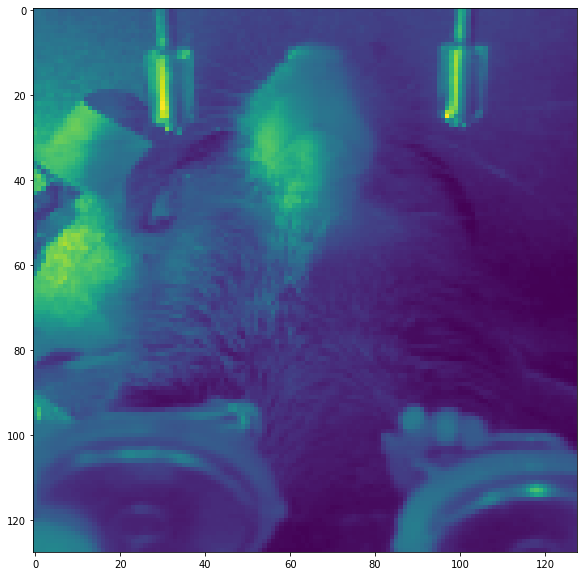

In [ ]:
exmp_frame = video_train[5000, :, :]
#np.shape(exmp_frame)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(exmp_frame)

## sklearn PCA benchmark

In [ ]:
frames, x, y = np.shape(video_train)
fl_video_train = video_train.reshape(frames, -1)
pca_model = PCA(n_components=15)
pca_model.fit(fl_video_train)

PCA(n_components=15)

In [ ]:
PCA_vdtrain = pca_model.transform(fl_video_train)

In [ ]:
pca_eig = pca_model.components_

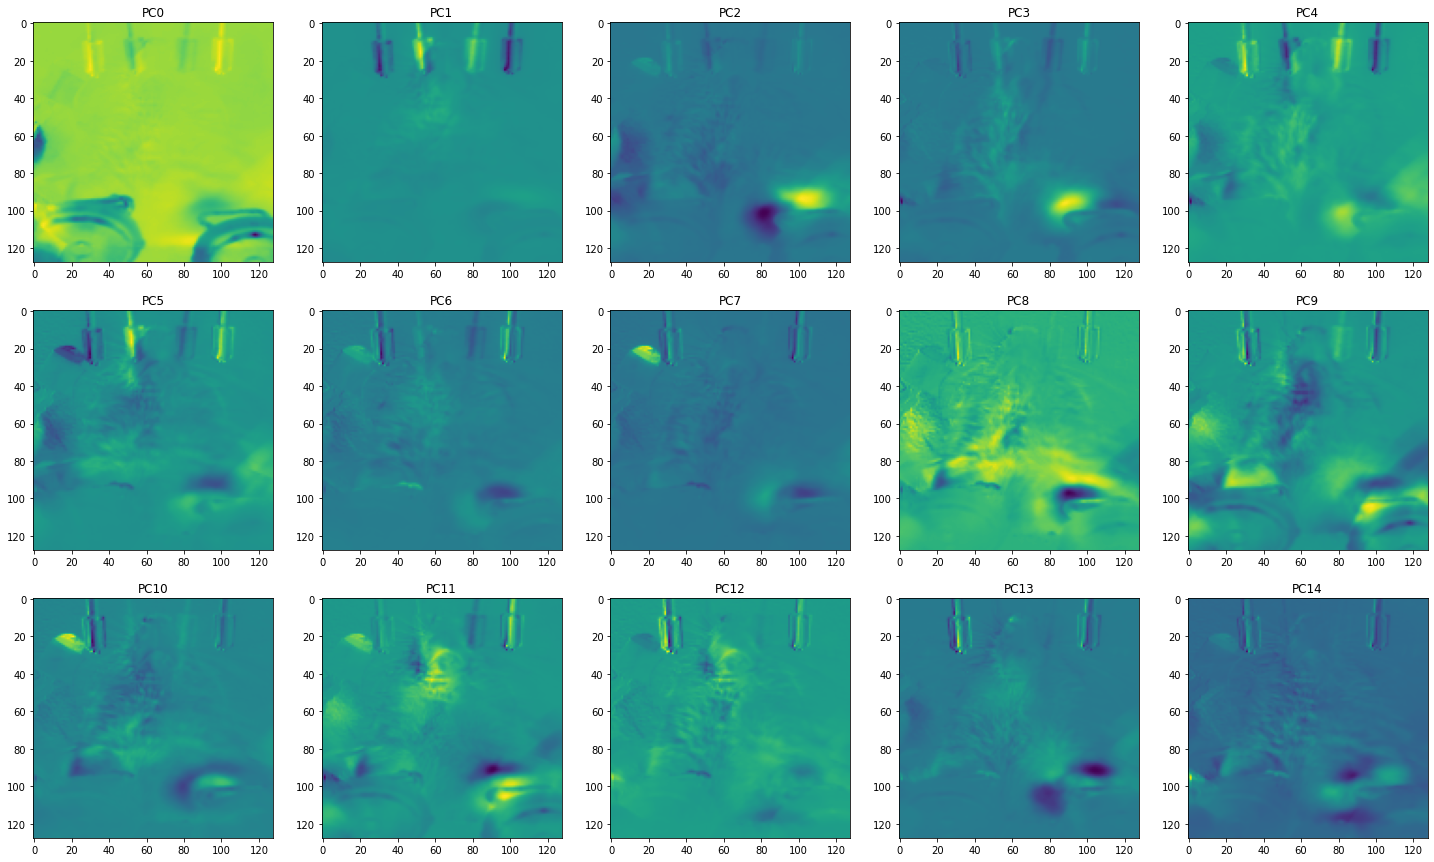

In [ ]:
fig, ax = plt.subplots(3,5,figsize=(25,15))

# Iterate over the 15 columns of the figure
for i in range(15):
  # Reshape the i-th column of svd_components into a 128x128 matrix
  PC = pca_eig[i,:].reshape(128,128)
  
  # Compute the row and column indices of the current subplot
  row = int(np.floor(i/5))
  col = i % 5
  
  # Plot the i-th principal component as an image in the current subplot
  ax[row, col].imshow(PC)
  ax[row, col].set_title('PC'+str(i))

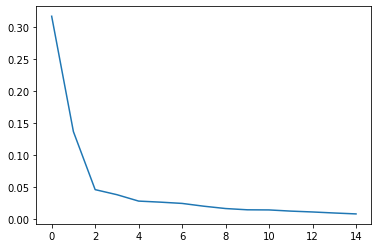

In [ ]:
plt.plot(pca_model.explained_variance_ratio_)

## Dimensionality Reduction (random SVD)

In [ ]:
# reshape video train and test
frames, x, y = np.shape(video_train)  # get the number of frames, x and y dimensions for the train video
fl_video_train = video_train.reshape(frames, -1)  # reshape the train video into a 2D matrix with dimensions (frames, xy)
framest, x, y = np.shape(video_test) # get the number of frames, x and y dimensions for the test video
fl_video_test = video_test.reshape(framest, -1) # reshape the test video into a 2D matrix with dimensions (frames, xy)

In [ ]:
# center video train and test
fl_video_test = fl_video_test - fl_video_test.mean()
fl_video_train = fl_video_train - fl_video_train.mean() 
#fl_video_test = (fl_video_test - fl_video_test.mean()) / fl_video_test.std(ddof=0)
#fl_video_train = (fl_video_train - fl_video_train.mean()) / fl_video_train.std(ddof=0)

Here we define a function fast_svd that attempts to compute the singular value decomposition (SVD) of a matrix A using a randomized algorithm. The algorithm operates by iteratively multiplying A by a random Gaussian matrix G and then using the QR decomposition to find an approximate SVD of the resulting matrix. The number of iterations, or equivalently the accuracy of the approximation, is controlled by the input i.

In [ ]:
# implement random matrix projection SVD for large dataset

def fast_svd(A, k, q, p):
  dim1 = np.shape(A)[1]  # Get the second dimension of A
  G = np.random.rand(dim1,k+p)  # Create a random Gaussian matrix oversampled by p
  H = A @ G
  for i in range(q): # Power iteration
    H = A @ (np.transpose(A) @ H) # update H
  Q, R = np.linalg.qr(H, mode = 'reduced')  # Compute the QR decomposition of H
  T = np.transpose(Q) @ A  # Compute the product of the transpose of A and Q
  Uh, S, Vt = np.linalg.svd(T, full_matrices=False)  # Compute the SVD of T
  U = Q @ Uh  # Compute the product of Q and Vh
  return U,S,Vt  # Return the matrices U, S, and V as the output of the function


In [ ]:
 # compute the randomized SVD of the reshaped train video
U,S,V = fast_svd(fl_video_train, 15, 1, 5)
U_re = fl_video_train @ np.transpose(V) 
Ut_re = fl_video_test @ np.transpose(V)  

In [ ]:
var_explained = np.cumsum(S**2)/np.cumsum(S**2)[-1]
var_explained15 = var_explained[14]
print('Variance explaine dby the top 15 componenets is', var_explained15)

Variance explaine dby the top 15 componenets is 0.9978733908530711


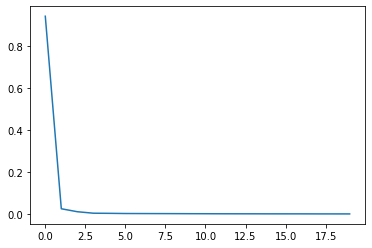

In [ ]:
# componenet explained variance drop very fast
plt.plot(S**2/np.sum(S**2))

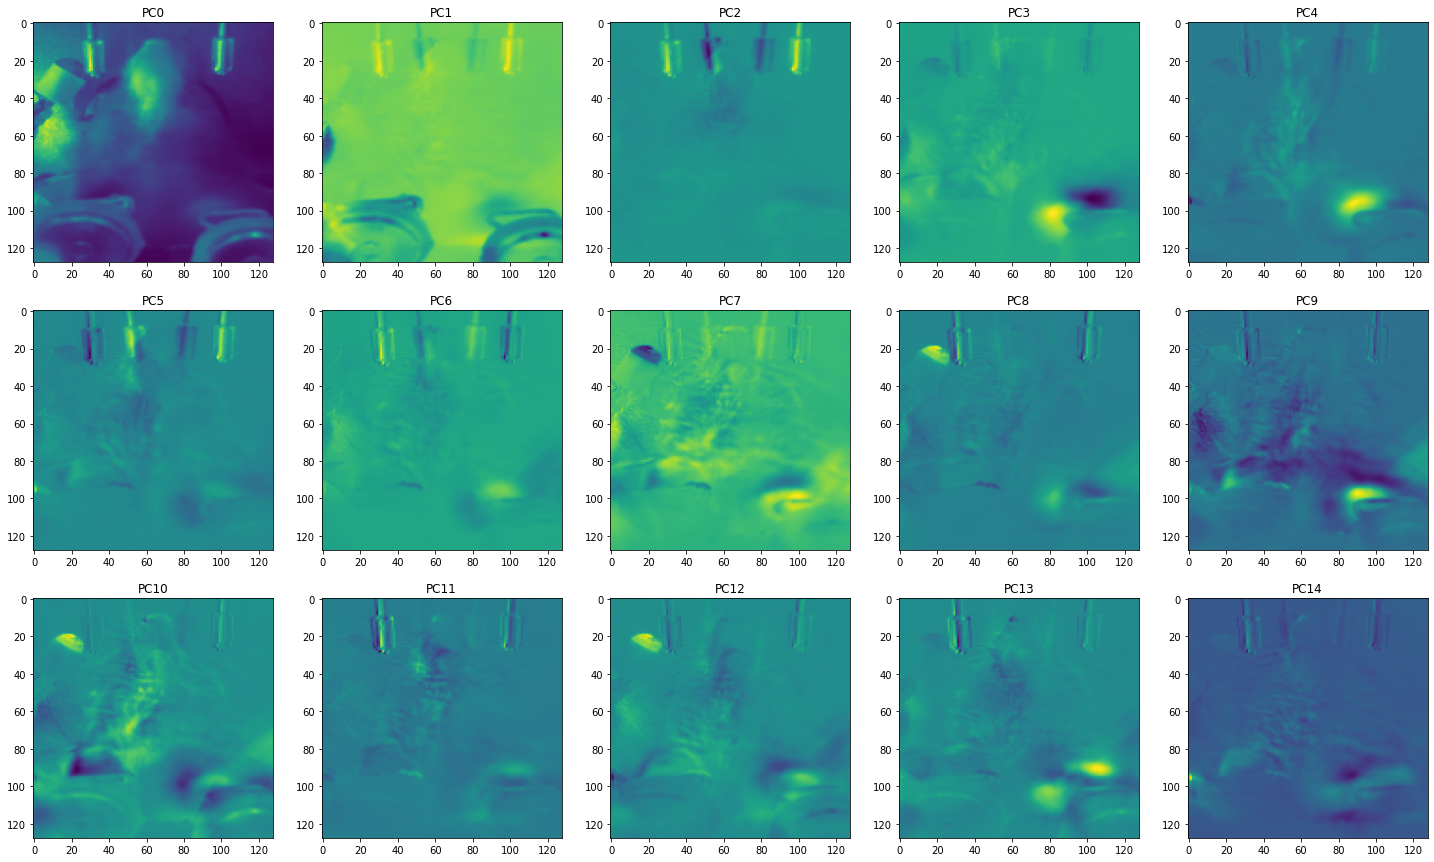

In [ ]:
# Compute the SVD components by taking the product of U and the diagonal matrix S
# svd_components = np.diag(S) @ V

# Create a new figure with 3 rows and 5 columns
fig, ax = plt.subplots(3,5,figsize=(25,15))

# Iterate over the 15 columns of the figure
for i in range(15):
  # Reshape the i-th column of svd_components into a 128x128 matrix
  PC = V[i,:].reshape(128,128)
  
  # Compute the row and column indices of the current subplot
  row = int(np.floor(i/5))
  col = i % 5
  
  # Plot the i-th principal component as an image in the current subplot
  ax[row, col].imshow(PC)
  ax[row, col].set_title('PC'+str(i))

In [ ]:
# reconstruction
SVD_recon = U[:,0:15] @ np.diag(S[0:15]) @ V[0:15,:]

Text(0.5, 1.0, 'svd reconstructed video frame 5000')

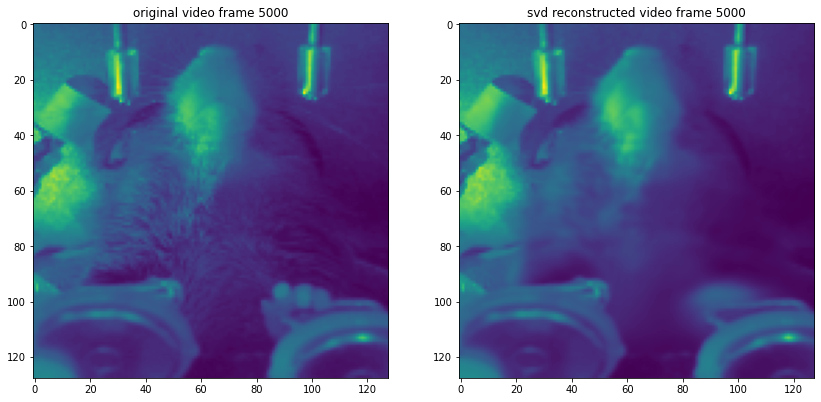

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,7))
exmp_frame_ori = video_train[5000, :, :]
exmp_frame_svd = SVD_recon[5000, :]
#np.shape(exmp_frame)
ax[0].imshow(exmp_frame_ori)
ax[0].set_title('original video frame 5000')
ax[1].imshow(exmp_frame_svd.reshape(128,128))
ax[1].set_title('svd reconstructed video frame 5000')

# Part 2: Linear and nonlinear decoding of behavioral video PCA components


Here we load the training and test data for the model, which are singular value decomposition (SVD) components. The code then divides each column of the test and train data by the maximum value in that column, and stores the resulting matrices in SVD_test and SVD_train, respectively.

The purpose of this normalization step is to scale the values in each column of the SVD data to the same range, which can help to improve the performance of the machine learning model. This is a common preprocessing step in machine learning, as it can help to ensure that the model is not dominated by any one feature.

In [ ]:
# Load the training and test data for the model, which are matrices of SVD components
SVD_train = U_re[:,0:15]
SVD_test = Ut_re[:,0:15]

# Compute the maximum value in each column of the training data
SVD_scores_max_train = np.max(SVD_train, axis=0)

# Divide each column of the test and train data by the corresponding maximum value
SVD_test = SVD_test/SVD_scores_max_train
SVD_train = SVD_train/SVD_scores_max_train


## Linear Model (linear regression)

This part computes the mean squared error (MSE) between the SVD test data and the mean of the SVD training data. This MSE value can be used as a baseline for evaluating the performance of a machine learning model on the data. If the model can achieve an MSE that is significantly lower than this baseline, it is likely to be performing well on the data.

In [ ]:
# Calculate the mean of each column in the SVD train data
SVD_mean = np.mean(SVD_train, axis=0).reshape(1,15)
# Compute the mean squared error between the test data and the mean of the training data
musall_baseline_mse = ((SVD_test - SVD_mean)**2).mean(axis = 1)

In [ ]:
from numpy.linalg import matrix_rank
rank_neural = matrix_rank(neural_train)

In [ ]:
rank_neural == np.shape(neural_train)[1]

True

Rank of X matrix (neural_train) is full-rank (rank = 258), so normal equation has unique solution beta. 

In [ ]:
# write a linear regression class
class LinearRegression:
    # initialize the LinearRegression class with an optional fit_intercept argument
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
    # define a pad method to add a column of ones to the input data
    def pad(self, X):
        pad_column = np.ones((np.shape(X)[0],1))
        pad_X = np.concatenate((X, pad_column), axis = 1)
        return pad_X
    # define a fit method to train the linear regression model on the input data
    def fit(self, X, y):
        # check if the fit_intercept argument is set to True, and if so, add a column of ones to the input data
        if self.fit_intercept:
            X = self.pad(X)
        # calculate the beta coefficients for the linear regression model
        xtx = np.dot(X.T, X)
        inv_xtx = np.linalg.inv(xtx)
        xty = np.dot(X.T, y)
        self.beta = np.dot(inv_xtx, xty)
        
    def predict(self, X):
        if self.fit_intercept:
            X = self.pad(X)
        return np.dot(X, self.beta)
    # define a mse method to calculate the mean squared error for the predictions   
    def mse(self, X, y):
        pre_y = self.predict(X)
        ele_mse = np.mean((pre_y - y)**2, axis = 1)
        overall_mse = np.mean((pre_y - y)**2)
        return ele_mse, overall_mse
        

In [ ]:
# fit linear model
model_lin = LinearRegression(fit_intercept=True)
# train the linear model on the neural_train and SVD_train data
model_lin.fit(neural_train, SVD_train)
# make predictions using the trained model on the neural_test data
pred_output = model_lin.predict(neural_test)
# calculate the mean squared error for the whole test set and for each element of the test set
musall_ele_mse, musall_overall_mse = model_lin.mse(neural_test,SVD_test)

In [ ]:
musall_overall_mse

0.05535169310804309

## Nonlinear Model (neural network)

In [ ]:
# define train test dataset
# shuffle the neural_train and SVD_train datasets and store them in the x_train and y_train variables
x_train, y_train = shuffle(neural_train, SVD_train, random_state = 0)
# shuffle the neural_test and SVD_test datasets and store them in the x_test and y_test variables
x_test, y_test = shuffle(neural_test, SVD_test, random_state = 0)
# shuffle the y_train dataset and store it in the y_train_null variable
y_train_null = shuffle(y_train)
# set the number of epochs to 50
epochs = 50

In [ ]:
# construct neural network model
model_nn = tf.keras.models.Sequential([
  tf.keras.layers.Dense(258),
  tf.keras.layers.Dense(50, activation='relu'),
  tf.keras.layers.Dense(15)
])
# compile the model with the Adam optimizer, mean squared error loss, and mean squared error metric
model_nn.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mean_squared_error'])
# train the model on the x_train and y_train data for the specified number of epochs
# with a specified validation split and suppressing the training progress output
model_history = model_nn.fit(x_train, y_train, epochs=epochs, validation_split=0.2, verbose=0)

Similarly we can train the null model for comparison:

In [ ]:
# construct neural network model
model_null = tf.keras.models.Sequential([
  tf.keras.layers.Dense(258),
  tf.keras.layers.Dense(50, activation='relu'),
  tf.keras.layers.Dense(15)
])
# compile the model with the Adam optimizer, mean squared error loss, and mean squared error metric
model_null.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mean_squared_error'])
# train the model on the x_train and y_train data for the specified number of epochs
# with a specified validation split and suppressing the training progress output
null_model_history = model_null.fit(x_train, y_train_null, epochs=epochs, validation_split=0.2, verbose=0)

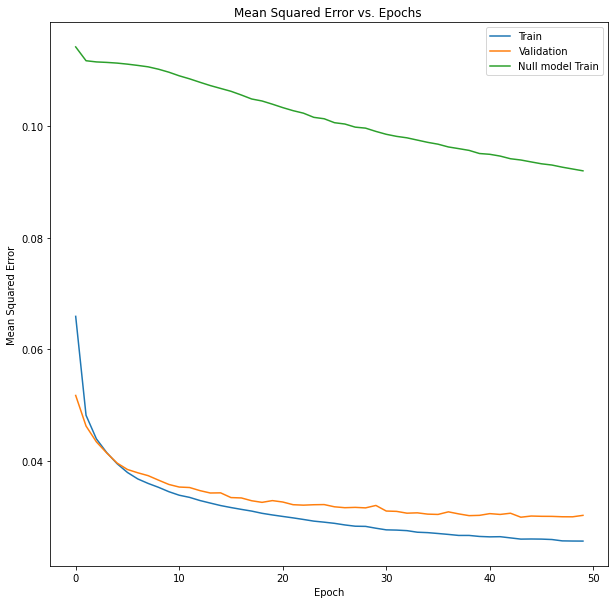

In [ ]:
import matplotlib.pyplot as plt
# create figure and axes objects for the plot
fig, ax = plt.subplots(figsize=(10,10))
# plot the mean squared error for the training set as a function of the epoch number
ax.plot(range(epochs), model_history.history['mean_squared_error'], label='Train')
# plot the mean squared error for the validation set as a function of the epoch number
ax.plot(range(epochs), model_history.history['val_mean_squared_error'], label='Validation')
# plot the mean squared error for the null model as a function of the epoch number
ax.plot(range(epochs), null_model_history.history['mean_squared_error'], label='Null model Train')
ax.set(title='Mean Squared Error vs. Epochs ', xlabel='Epoch', ylabel='Mean Squared Error')
ax.legend()

In [ ]:

# Initialize the mean squared error metric
mse_values=[]
# Iterate over the test set and calculate the MSE for each element
for i in range(x_test.shape[0]):
  # Make predictions on the test element
  predictions = model_nn(x_test[:i+1])
  # Get the MSE values for each test element
  mse = mean_squared_error(predictions, y_test[:i+1])
  mse_values.append(mse)


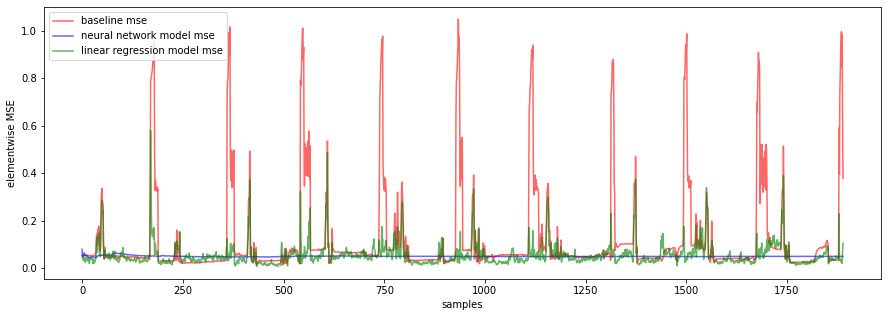

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(musall_baseline_mse, label = 'baseline mse',color = 'red',alpha=0.6) # plot the baseline MSE
ax.plot(mse_values,label = 'neural network model mse',color = 'blue',alpha=0.6) # plot the MSE of the neural network model

ax.plot(musall_ele_mse, label = 'linear regression model mse',color = 'green',alpha=0.6) # plot the MSE of the linear regression model
ax.set_xlabel('samples')
ax.set_ylabel('elementwise MSE')
ax.legend()

In [ ]:
adv_nn = mse_values - musall_ele_mse
lin_best = np.argmax(adv_nn)
nn_best = np.argmin(adv_nn)

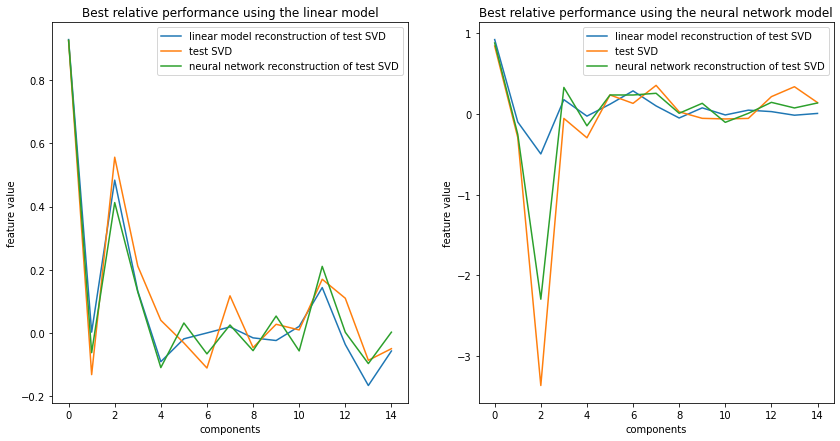

In [ ]:
modellin_pred = model_lin.predict(neural_test)
nn_pred = model_nn(neural_test)
fig, ax = plt.subplots(1,2,figsize=(14, 7))
ax[0].plot(modellin_pred[lin_best],label='linear model reconstruction of test SVD')
ax[0].plot(SVD_test[lin_best],label='test SVD')
ax[0].plot(nn_pred[lin_best],label='neural network reconstruction of test SVD')
ax[0].set_xlabel('components')
ax[0].set_ylabel('feature value')
ax[0].set_title('Best relative performance using the linear model')
ax[0].legend()
ax[1].plot(modellin_pred[nn_best],label='linear model reconstruction of test SVD')
ax[1].plot(SVD_test[nn_best],label='test SVD')
ax[1].plot(nn_pred[nn_best],label='neural network reconstruction of test SVD')
ax[1].set_xlabel('components')
ax[1].set_ylabel('feature value')
ax[1].set_title('Best relative performance using the neural network model')
ax[1].legend()